In [1]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Input, Model
from keras.layers import Dense, Layer
from pycalphad import Database, calculate, variables as v
import numpy as np

In [2]:
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'SI', 'VA']

In [3]:
import pycalphad
mod = pycalphad.Model(dbf, comps, 'LIQUID')
#del mod.models['idmix']
#del mod.models['ref']
print(mod.models)
res = calculate(dbf, comps, 'LIQUID', T=(300, 2000, 10), P=1e5, N=1, model=mod, pdens=10)

OrderedDict([('ref', (LIQUID0MG*Piecewise((8202.243 - 8.83693*T - 8.0176e-20*T**7 + Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.716215*T - 34.3088*T*log(T) + 1.038192e+28*T**(-9), And(T < 3000.0, 923.0 <= T)), (0, True)), And(T < 923.0, 298.15 <= T)), (8690.316 - 9.392158*T - 1.038192e+28*T**(-9) + Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.716215*T - 34.3088*T*log(T) + 1.038192e+28*T**(-9), And(T < 3000.0, 923.0 <= T)), (0, True)), And(T < 6000.0, 923.0 <= T)), (0, True)) + LIQUID0SI*Piecewise((50696.4 - 30.0994*T + 2.09307e-21*T**7 + Piecewise((-8162.609 + 137.236859*T - 22.8317533*T*log(T) + 176667*T**(-1) - 0.001912904*T**2 - 3.552e-09*T**3, And(T < 1687.0, 298.15 <= T)), (-9457.642 + 167.281367*T - 27.196*T*log(T) - 4.20369e+30*T**(-9), And(T < 3600.0, 1

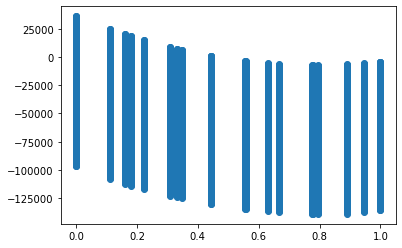

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(res.Y[..., 0], res.GM)

In [5]:
site_fractions = res.Y.values
print(site_fractions.shape)

(1, 1, 170, 22, 2)


In [6]:
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .drop_duplicates()\
                .reset_index()\
                .drop(columns=['N', 'P', 'points'])
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .reset_index().drop(columns=['N', 'P', 'points'])
print(filtered.shape)
# Not sure how to fix the duplicate energy column yet
filtered = filtered.values[:, :1+site_fractions.shape[-1]+1]
x_orig = filtered[:, :-1]
y_orig = filtered[:, -1]

(7480, 5)


C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
filtered

array([[ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
        -4.25029576e+03],
       [ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
        -4.25029576e+03],
       [ 3.00000000e+02,  1.00000000e-14,  1.00000000e+00,
         3.60234556e+04],
       ...,
       [ 1.99000000e+03,  1.81042920e-01,  8.18957080e-01,
        -1.13998907e+05],
       [ 1.99000000e+03,  7.94906213e-01,  2.05093787e-01,
        -1.38895015e+05],
       [ 1.99000000e+03,  7.94906213e-01,  2.05093787e-01,
        -1.38895015e+05]])

In [19]:
class ConcatLayer(Layer):
    def __init__(self, temp_scale=1.0):
        super().__init__()
        self.temp_scale = float(temp_scale)
    def call(self, inputs):
        scaled_inputs = inputs * tf.constant([1./self.temp_scale, 1.0, 1.0])
        return scaled_inputs
        #return tf.concat([scaled_inputs, tf.math.log(scaled_inputs[..., :1])], axis=-1)

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, BatchNormalization, LayerNormalization, Dot
from tensorflow_addons.layers import PolynomialCrossing

x = x_orig.copy()
#x[:, 0] /= x_orig[:, 0].std()
print('Number of training points: ', x.shape[0])
y_unscaled = y_orig #- 8.3145 * x_orig[:, 0] * (x_orig[:, 1] * np.log(x_orig[:, 1]) + x[:, 2] * np.log(x_orig[:, 2]))
y = y_unscaled #/ y_unscaled.std() # (y_unscaled - y_unscaled.mean())/y_unscaled.std()
print('Number of features: ', x.shape[1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1769)
inputs = Input(shape=(x.shape[1],))
x0 = ConcatLayer(temp_scale=x_orig[:, 0].max())(inputs)
#x0 = inputs
#x0 = BatchNormalization()(x0)
output = PolynomialCrossing(projection_dim=None, use_bias=False)((x0, x0))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((x0, output))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((x0, output))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((x0, output))
output = y_unscaled.std() * tf.math.reduce_sum(output, axis=-1) + \
    8.3145*inputs[...,0] * (inputs[...,1]*tf.math.log(inputs[...,1]) + inputs[...,2]*tf.math.log(inputs[...,2]))
linear_model = Model(inputs, output)
#linear_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=False), loss='mse')
linear_model.compile(optimizer='adam', loss='mae')

Number of training points:  7480
Number of features:  3


In [37]:
ConcatLayer(temp_scale=x_orig[:, 0].max())(x_test)

<tf.Tensor: shape=(748, 3), dtype=float32, numpy=
array([[0.22110553, 0.7777778 , 0.22222222],
       [0.7839196 , 0.44444445, 0.5555556 ],
       [0.6482412 , 0.63092977, 0.36907023],
       ...,
       [0.18090452, 0.5555556 , 0.44444445],
       [0.44723618, 0.5555556 , 0.44444445],
       [0.60301507, 0.44444445, 0.5555556 ]], dtype=float32)>

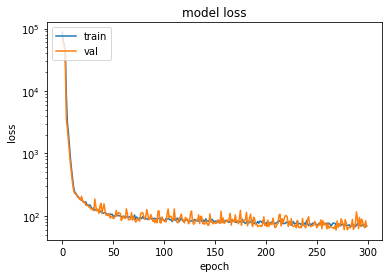

In [38]:
# Fit on training data
history = linear_model.fit(x=x_train, y=y_train, epochs=300, validation_data=(x_test, y_test), verbose=0,
                           callbacks=keras.callbacks.TerminateOnNaN())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

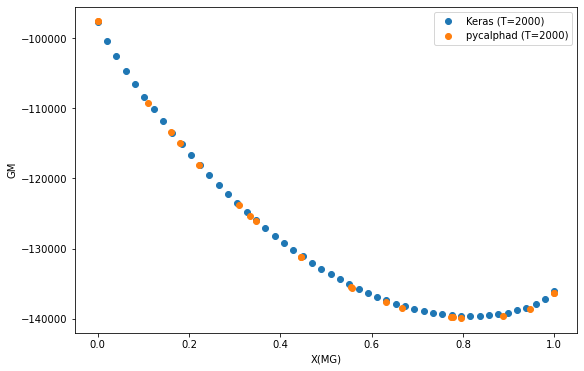

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import pycalphad

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_at_temp(temp):
    x_start = np.array([temp,1e-4, 1-1e-4])
    x_end = np.array([temp, 1-1e-4, 1e-4])
    x_interp = np.linspace(x_start, x_end, num=50)
    model_y = linear_model.predict(x_interp, batch_size=1)
    mod = pycalphad.Model(dbf, comps, 'LIQUID')
    #del mod.models['idmix']
    #del mod.models['ref']
    test_calc = calculate(dbf, comps, 'LIQUID', T=temp, P=1e5, N=1, model=mod, pdens=10)
    px_idx = np.argsort(x_interp[:, 1])
    px = x_interp[px_idx, 1]
    model_py = model_y[px_idx] #(model_y[px_idx] * y_unscaled.std()) #+ y_unscaled.mean()
    ax.scatter(px, model_py, label=f'Keras (T={temp})')
    ax.scatter(np.squeeze(test_calc.Y.values)[:, 0], np.squeeze(test_calc.GM.values), label=f'pycalphad (T={temp})')
#plot_at_temp(300)
#plot_at_temp(700)
plot_at_temp(2000)
ax.set_xlabel('X(MG)')
ax.set_ylabel('GM')
ax.legend()

C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\numpy\lib\function_base.py:1089: RuntimeWarning: invalid v

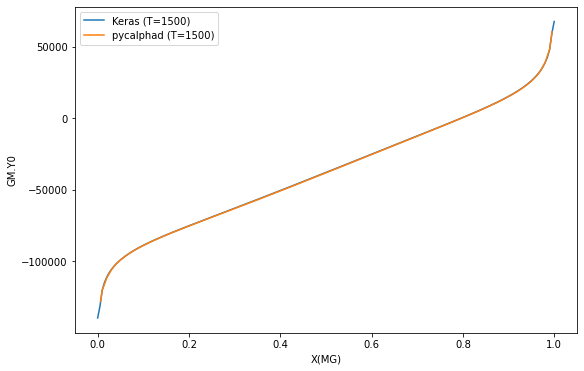

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_gradient_at_temp(temp):
    x_start = np.array([temp,1e-4, 1-1e-4])
    x_end = np.array([temp, 1-1e-4, 1e-4])
    x_interp = np.linspace(x_start, x_end, num=200)
    model_y = linear_model.predict(x_interp, batch_size=1)
    mod = pycalphad.Model(dbf, comps, 'LIQUID')
    #del mod.models['idmix']
    #del mod.models['ref']
    test_calc = calculate(dbf, comps, 'LIQUID', T=temp, P=1e5, N=1, model=mod, pdens=100)
    px_idx = np.argsort(x_interp[:, 1])
    px = x_interp[px_idx, 1]
    model_py = model_y[px_idx] #(model_y[px_idx] * y_unscaled.std())# + y_unscaled.mean()
    ax.plot(px, np.gradient(model_py, px), label=f'Keras (T={temp})')
    px_idx = np.argsort(np.squeeze(test_calc.Y.values)[:,0])
    px = np.squeeze(test_calc.Y.values)[:, 0][px_idx]
    ax.plot(px, np.gradient(np.squeeze(test_calc.GM.values)[px_idx], px), label=f'pycalphad (T={temp})')
#plot_gradient_at_temp(300)
#plot_gradient_at_temp(700)
plot_gradient_at_temp(1500)
ax.set_xlabel('X(MG)')
ax.set_ylabel('GM.Y0')
ax.legend()

In [41]:
layer_outputs = [layer.output for layer in linear_model.layers] 
# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=linear_model.input, outputs=layer_outputs)

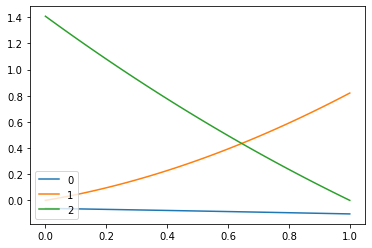

In [48]:
temp = 300
x_start = np.array([temp,1e-4, 1-1e-4])
x_end = np.array([temp, 1-1e-4, 1e-4])
x_interp = np.linspace(x_start, x_end, num=100)
activations = activation_model.predict(x_interp)
[plt.plot(x_interp[:,1], act, label=idx) for idx, act in enumerate(activations[3].T)]
plt.legend(loc='lower left')

In [44]:
linear_model.weights

[<tf.Variable 'polynomial_crossing_8/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-1.1050153 ,  0.25488788,  0.02374172],
        [-0.7127949 , -0.06841902,  0.11021529],
        [-0.5000472 , -0.05611057,  0.17037556]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_9/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.5656918 , -0.01663062, -0.08904985],
        [-0.820989  , -0.15346809,  0.01829454],
        [-0.6035049 , -0.50234336,  0.20327854]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_10/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.09216434,  0.00309938, -0.0651369 ],
        [-0.706058  , -0.6558504 , -0.6258191 ],
        [-0.5988725 , -0.61794287, -0.04177957]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_11/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.394434  ,  0.32172978,  0.25721967],
        [-0.63514596, -0.31183788, -1.2003562 ],
        [-0.51570183, -0.8347101 , -0.08506978]], dtype=float32)>]